**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ scipy 1.1.0
+ statsmodels 0.9.0

# Заработная плата в России
В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.
Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
salaries = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salaries.columns = ["Salary"]
salaries.head()

,Salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


<Figure size 1080x504 with 0 Axes>

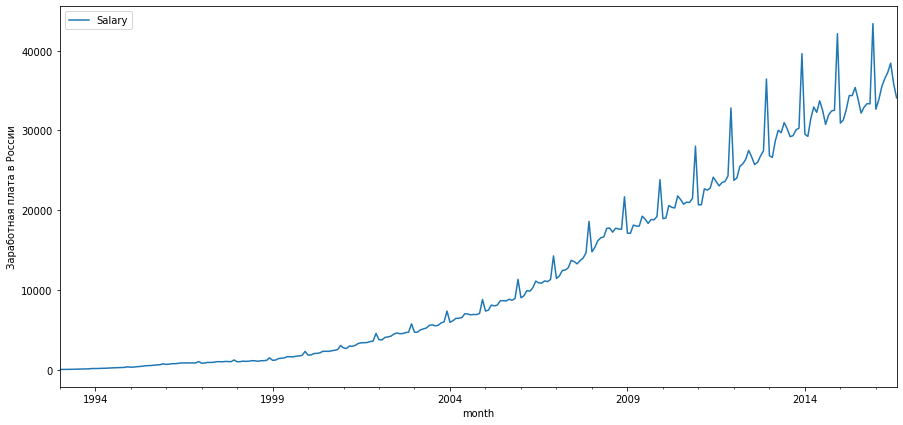

In [3]:
plt.figure(figsize(15,7))
salaries.plot()
pylab.ylabel("Заработная плата в России")
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

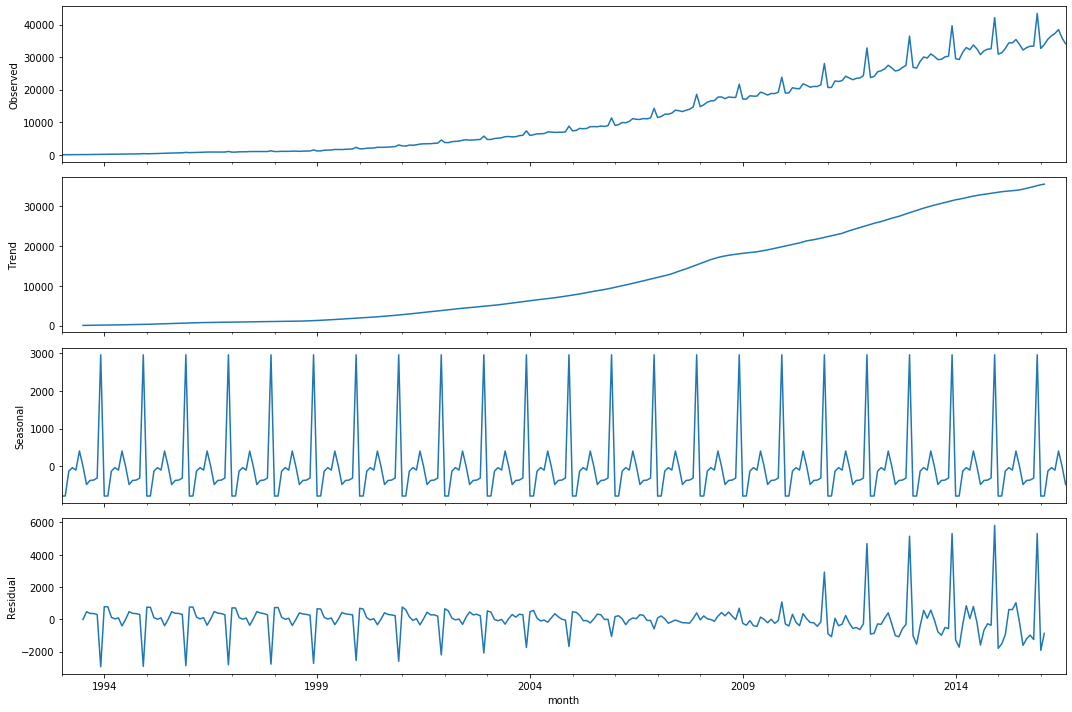

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salaries.Salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries.Salary)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


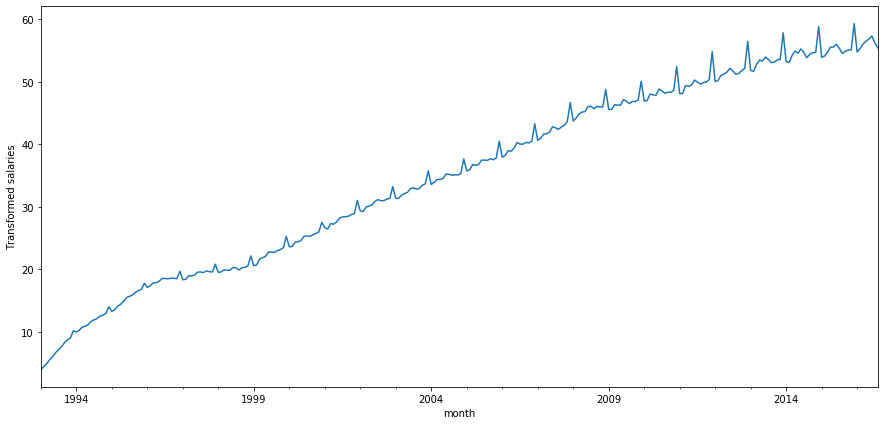

In [5]:
salaries['s_box'], lmbda = stats.boxcox(salaries.Salary)
plt.figure(figsize(15,7))
salaries.s_box.plot()
plt.ylabel(u'Transformed salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries.s_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

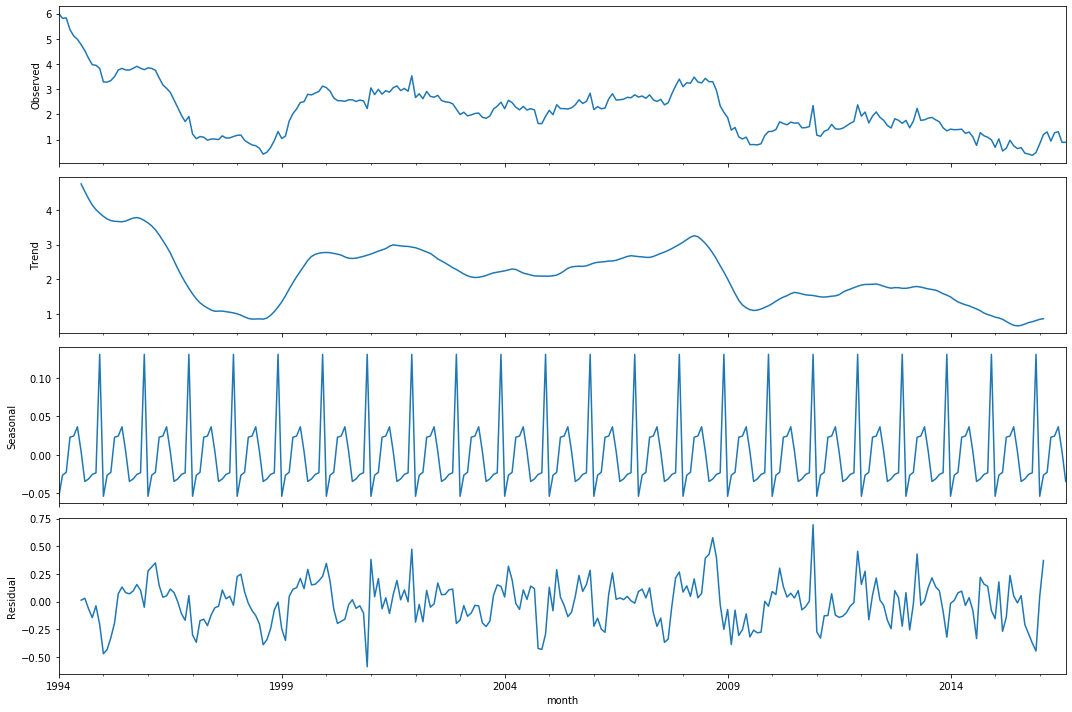

In [6]:
salaries['s_box_diff'] = salaries.s_box - salaries.s_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salaries.s_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries.s_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

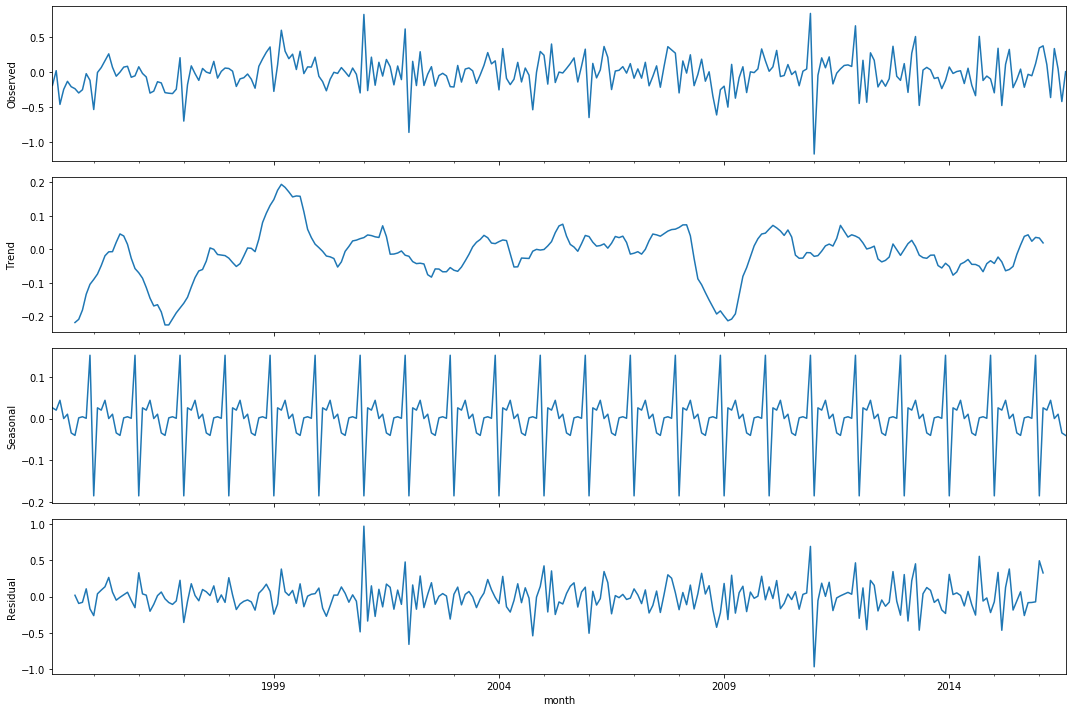

In [7]:
salaries['s_box_diff2'] = salaries.s_box_diff - salaries.s_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salaries.s_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries.s_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

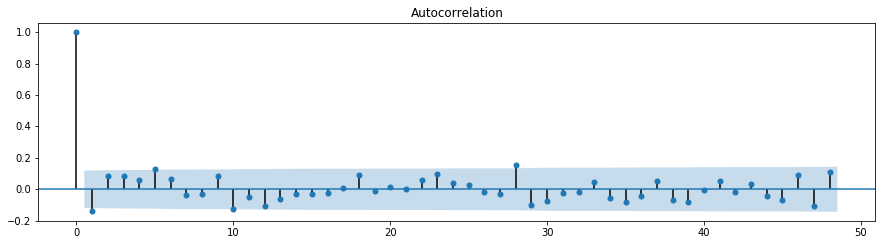

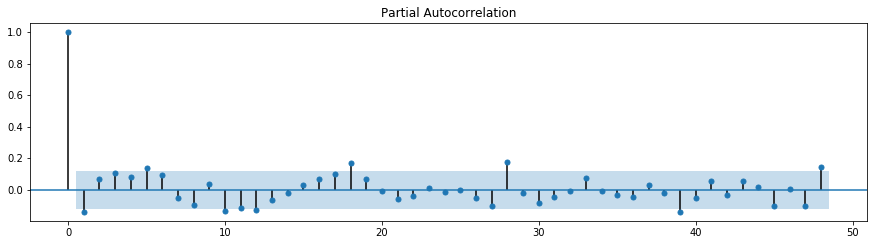

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salaries.s_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salaries.s_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=5, P=1, p=5

In [9]:
Qs = range(0, 1)
qs = range(0, 6)
Ps = range(0, 2)
ps = range(0, 6)
d=1
D=1
S=12

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salaries.s_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], S)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 2min 17s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
71  (5, 5, 1, 0) -25.090430
59  (4, 5, 1, 0) -23.862231
70  (5, 5, 0, 0) -22.316118
28  (2, 2, 0, 0) -21.488595
29  (2, 2, 1, 0) -21.473461


Лучшая модель:

In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              s_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.545
Date:                            Fri, 08 May 2020   AIC                            -25.090
Time:                                    12:10:51   BIC                             18.135
Sample:                                01-01-1993   HQIC                            -7.735
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2200      0.594     -0.371      0.711      -1.384       0.944
ar.L2          0.2427      0.418   

Её остатки:

Критерий Стьюдента: p=0.162261
Критерий Дики-Фуллера: p=0.000000


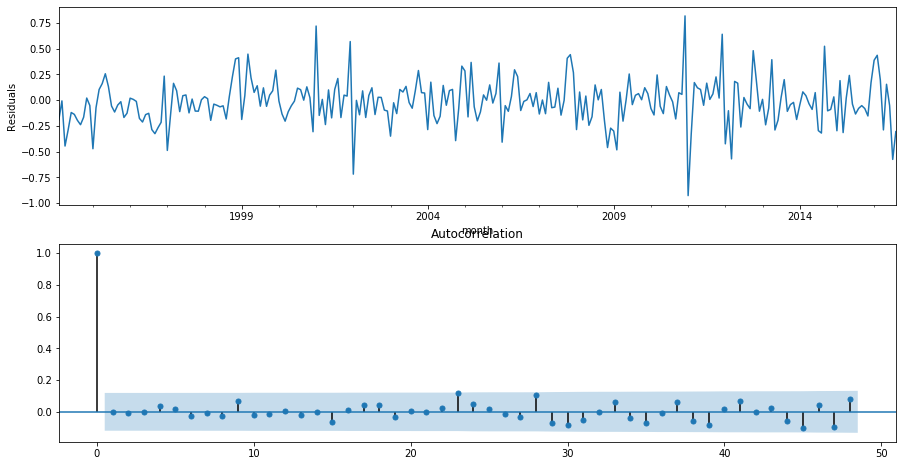

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

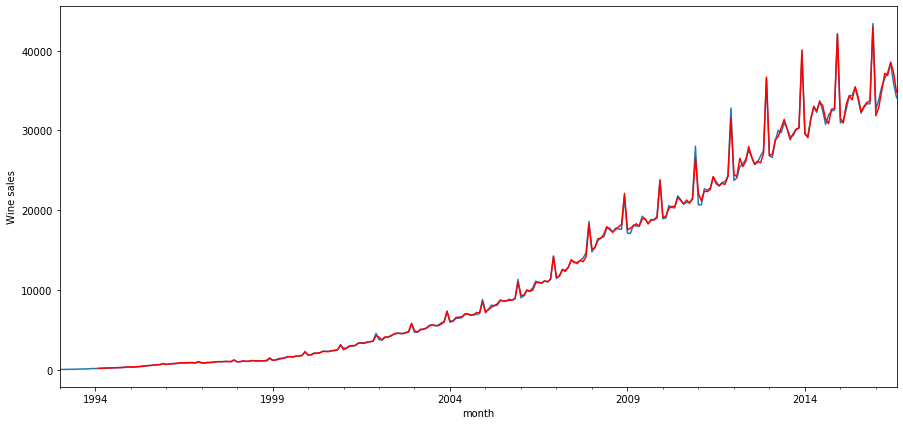

In [15]:
salaries['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salaries.Salary.plot()
salaries.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

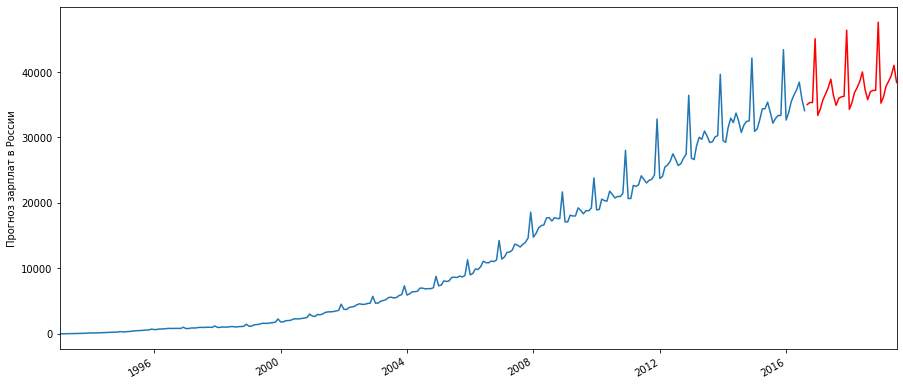

In [16]:
salaries_forecast = salaries[["Salary"]]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=salaries_forecast.columns)
salaries_forecast = pd.concat([salaries_forecast, future])
salaries_forecast["forecast"] = invboxcox(best_model.predict(start=284, end=284+36), lmbda)

pylab.figure(figsize(15,7))
salaries_forecast["Salary"].plot()
salaries_forecast["forecast"].plot(color='r')
pylab.ylabel(u"Прогноз зарплат в России")
pylab.show()